<a href="https://colab.research.google.com/github/CameronRobsonLeigh/Neural-Network-Image-predictions/blob/main/CameronRobsonNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install res-mlp-pytorch
!pip install torch-optimizer
!pip install patchify

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import matplotlib.pyplot as plt

In [ ]:
# here we create a random seed to get reproducible results by creating a fixed seed for py, numpy and pytorch.
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# 70,000 greyscale 28x28 images belonging to 10 different items of clothing
# X variables contain the 28x28 greyscale images, the Y variables contain the labels
# training 60k - testing 10k
from tensorflow.keras.datasets import fashion_mnist
import my_utils as mu


# retrieve dataset and put into variable, the root variable creates a folder locally.
ROOT = '.data'
training_data = datasets.FashionMNIST(root=ROOT, train=True, download=True)

# retrieve mean/std of the training set so that we can normalize our data.
# we normalize to speed up training and to train more reliable by avoiding high/low minima
# we demonstrate how to use the mean/std later
mean = training_data.data.float().mean() / 255
std = training_data.data.float().std() / 255

# A transform states how our data should be augmented and processed.
# Data augmentation involves manipulating the available training data in a way that artificially creates more training examples.
# We use transforms.Compose to built a list of transformations that will be applied to the image.
# below we create both our transforms
# essentially what transforms do is create artificial versions of each image so we have more knowledge on that image. For example the randomrotation will rotate the image to provide more info.
# we don't provide these methods on the testing however as the model will already be trained.
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

# create our train/test variables but with our normalized transforms
# the split of this data is 60000 for training and 10000 for testing
train_data = datasets.FashionMNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.FashionMNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

# create dataloaders with the specified batch size of 256 on our train/test data. We will be using these to train our model.
# we only need to shuffle our data if used for stochastic gradient descent.
BATCH_SIZE = 256
train_iterator = data.DataLoader(train_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)



In [ ]:
# function to display images
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

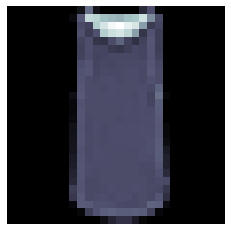

In [ ]:
# show images
N_IMAGES = 256
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
labels = [label for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(train_data[2])


In [ ]:
# using our train_iterator dataloader we create our own tensor with the structure of 256, 1, 28, 28.
# new lists and patch function
train_iter = []
test_iter = []
# patch function
def patch(x):
  zerozero, zeroone, zerotwo = 1,4,4
  oneone, onetwo, onethree = 1,4,4
  patches = x.unfold(1, zerozero, oneone).unfold(2, zeroone, onetwo).unfold(3, zerotwo, onethree)
  patches = patches.contiguous().view(patches.size(0), -1, zeroone*zerotwo)
  return patches

# iterations to append to our new lists.
for i in train_iterator:
  if len(i[1]) == 256:
    ptch = torch.transpose(patch(i[0]),2,1)
    train_iter.append([ptch, i[1]])

for i in test_iterator:
  if len(i[1]) == 256:
    ptch = torch.transpose(patch(i[0]),2,1)
    test_iter.append([ptch, i[1]])

In [ ]:
# our shape which entails 256 for batch size, 16 for patch size and 49 for pixels in each patch (7x7)
train_iter[0][0].shape

torch.Size([256, 16, 49])

In [ ]:
# Net class
class Net(torch.nn.Module):
    def __init__(self, num_inputs,  num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        # input layer, takes in 49 then outputs 16 neurons
        self.Linear1 = nn.Linear(num_inputs, 16)
        self.Linear2 = nn.Linear(16, 16)
        self.Linear3 = nn.Linear(16, 16)
        self.Linear4 = nn.Linear(16, 50)
        self.Linear5 = nn.Linear(50, 25)
        # output layer passes through 10 defining each item of classes
        self.Linear6 = nn.Linear(25, num_outputs)
        # ReLU defines our non-linear activation function making it easier for a neural network model to adapt with a variety of data and to differentiate between the outcomes
        self.relu = nn.ReLU()
        # define dropout function, p defines the probability of a neuron being
        # deactivated.
        self.Dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # 1 mlp
        x = self.Linear1(x)
        x = torch.transpose(x,1,2)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x)

        # next step
        x = torch.transpose(x,1,2)

        # 2 mlp
        x = self.Linear4(x)
        x = self.relu(x)
        x = self.Linear5(x)

        # drop out function
        # drop outs work by randomly disabling neurons and their corresponding connections.
        # Preventing the network from relying too much on single neurons and forces all neurons
        # to learn to generalize better.
        x = self.Dropout(x)

        out = self.Linear6(x)
        out = torch.mean(out, dim=1)
        return out

In [ ]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):
    """Train a model."""
    animator = mu.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = mu.train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

In [ ]:
# Model instantiation and initialisation
def init_weights(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.normal_(m.weight, std=0.1)
        torch.nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
# 49 inputs, number of pixels in each patch which is 7 by 7.
num_inputs, num_outputs = 49, 10

# Initialise your model here using init_weights function. If not done, default initiliazation will be used.
net = Net(num_inputs, num_outputs)
# applying init weights function
net.apply(init_weights)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys


Net(
  (Linear1): Linear(in_features=49, out_features=16, bias=True)
  (Linear2): Linear(in_features=16, out_features=16, bias=True)
  (Linear3): Linear(in_features=16, out_features=16, bias=True)
  (Linear4): Linear(in_features=16, out_features=50, bias=True)
  (Linear5): Linear(in_features=50, out_features=25, bias=True)
  (Linear6): Linear(in_features=25, out_features=10, bias=True)
  (relu): ReLU()
  (Dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# softmax regression
loss = nn.CrossEntropyLoss()
# learning rate of 0.01
lr = 0.01

# Making use of adam optimizer here.
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)

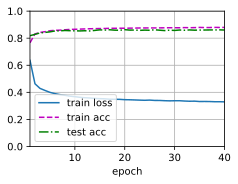

In [ ]:
num_epochs = 40

train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

In [ ]:
# run accuracy function
evaluate_accuracy(net, test_iter)

0.8617788461538461